In [9]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../modules')
from nsw.nsw_classifier import NSWClassifier
import nsw.data_gen as dg

# 1. Synthetic dataset - proof of concept

Classifer is building a graph. Data dimensionality detected is 2. regularity = 6
Classifier graph is build in 23.239s


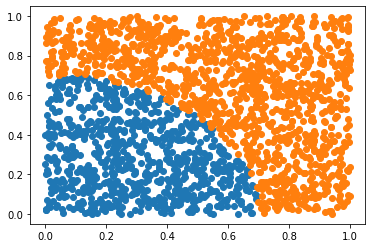

In [2]:
classifier = NSWClassifier()
data = dg.gen(N=2000, border=0.7)
classifier.build_navigable_graph(data, attempts=20)

# show classes
cls0 = np.array([r[0] for r in data if r[1] == 0])
cls1 = np.array([r[0] for r in data if r[1] == 1])
plt.scatter(cls0[:,0], cls0[:,1])
plt.scatter(cls1[:,0], cls1[:,1])
plt.show()

In [3]:
test = dg.gen(N=200, border=0.7)

path, knn = 0, 0
for t in test:
    path += classifier.classify_by_path(t[0], attempts=1) == t[1]
    knn += classifier.classify_knn(t[0], attempts=1) == t[1]
    
print(f"Path classifier accuracy = {100 * path / len(test):.2f}%")
print(f"Knn classifier accuracy = {100 * knn / len(test):.2f}%")

Path classifier accuracy = 99.00%
Knn classifier accuracy = 98.50%


# 2. Simple case: MINST

In [4]:
!python -m pip install mnist

In [5]:
from sklearn import datasets
import random

digits = datasets.load_digits()
X, Y = [x.flatten() for x in digits.images], digits.target
XY = list(zip(X, Y))
random.shuffle(XY)
train, test = XY[:4 * len(XY) // 5], XY[4 * len(XY) // 5:]

minst_classifier = NSWClassifier()
minst_classifier.build_navigable_graph(train, attempts=20)

Classifer is building a graph. Data dimensionality detected is 64. regularity = 192
Classifier graph is build in 134.907s


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
MNIST: Path classifier accuracy = 98.61%
MNIST: Knn classifier accuracy = 98.33%


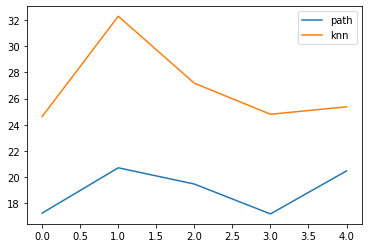

In [6]:
import time

path_times, knn_times = [], []
path, knn = 0, 0
times = 5

for i in range(times):
    print(f"iteration {i}")
    s = time.perf_counter()
    for t in test:
        path += minst_classifier.classify_by_path(t[0], attempts=1) == t[1]
    f = time.perf_counter()
    path_times.append(f - s)
    
    s = time.perf_counter()
    for t in test:
        knn += minst_classifier.classify_knn(t[0], attempts=1) == t[1]
    f = time.perf_counter()
    knn_times.append(f - s)

        
print(f"MNIST: Path classifier accuracy = {100 * path / len(test) / times:.2f}%")
print(f"MNIST: Knn classifier accuracy = {100 * knn / len(test) / times:.2f}%")

plt.plot(path_times, label="path")
plt.plot(knn_times, label="knn")
plt.legend()
plt.show()

# 3. Harder case: CIFAR-10

In [17]:
import shutil, os
import requests
import tarfile

filename = "cifar-10-python.tar.gz"
cifar_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

if not os.path.exists(filename):
    response = requests.get(cifar_url, stream=True)
    with open('cifar-10-python.tar.gz', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()

In [18]:
import pickle, numpy as np
folder = "cifar-10-batches-py"

datas = []
labels = []

for i in range(1, 6):
    with open(f"{folder}/data_batch_{i}", 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
        X, Y = batch[b'data'], [[x] for x in batch[b'labels']]
        datas.append(X)
        labels.append(Y)
        
with open(f"{folder}/test_batch", 'rb') as fo:
    batch = pickle.load(fo, encoding='bytes')
    Xtest, Ytest = batch[b'data'], [[x] for x in batch[b'labels']]
       
X = np.vstack(datas)
Y = np.vstack(labels)
print(X.shape, Y.shape)
XY = np.hstack((X, Y))
np.random.shuffle(XY)
X, Y = XY[:, :3072], XY[:, -1]

(50000, 3072) (50000, 1)


## 3.1. Reduce dimensions
PCA

In [19]:
from sklearn.decomposition import PCA

pca_reductor = PCA(n_components=16)
X_slim = pca_reductor.fit_transform(X)
Xtest_slim = pca_reductor.transform(Xtest)

Use classifier for dimensionality reduction

In [20]:
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.neural_network._base import ACTIVATIONS
# https://stackoverflow.com/questions/46728937/retrieve-final-hidden-activation-layer-output-from-sklearns-mlpclassifier

# still cool :)
def get_activations(clf, X):
        hidden_layer_sizes = list(clf.hidden_layer_sizes)
        hidden_activation = ACTIVATIONS[clf.activation]
        activations = [X]
        for i in range(clf.n_layers_ - 1):
            activations.append(safe_sparse_dot(activations[i], clf.coefs_[i]))
            activations[i+1] += clf.intercepts_[i]
            if (i + 1) != (clf.n_layers_ - 1):
                v = hidden_activation(activations[i+1])

        return activations

# X_reduced = np.array([get_activations(ann_classifier, vec)[-2] for vec in tqdm(X, position=0, leave=True)])
# Xtest_reduced = np.array([get_activations(ann_classifier, vec)[-2] for vec in tqdm(Xtest, position=0, leave=True)])

XY_reduced = list(zip(X_slim, Y))
XYtest = list(zip(Xtest_slim, Ytest))
XYtest_original = list(zip(Xtest, Ytest))

In [21]:
cifar_nsw_file = "../dumps/cifar10-16.graph"

if not os.path.exists(cifar_nsw_file):
    cifar_classifier = NSWClassifier()
    cifar_classifier.build_navigable_graph(XY_reduced, attempts=10, verbose=True)
    with open(cifar_nsw_file, "wb") as f:
        pickle.dump(cifar_classifier, f)
else:
    with open(cifar_nsw_file, "rb") as f:
        cifar_classifier = pickle.load(f)
path_times, knn_times, ann_times = [], [], []
path, knn, ann = 0, 0, 0
times = 3

Classifier is building a graph. Data dimensionality detected is 16. regularity = 48
	10.00% of graph construction
	20.00% of graph construction
	30.00% of graph construction
	40.00% of graph construction
	50.00% of graph construction
	60.00% of graph construction
	70.00% of graph construction
	80.00% of graph construction
	90.00% of graph construction
Classifier graph is build in 6715.035s


In [22]:
import time, sys
from tqdm import tqdm, trange

testx = XYtest[::20]

for i in range(times):
    print(f"iteration {i}")
    s = time.perf_counter()
    for t in tqdm(testx, position=0, leave=True):
        path += cifar_classifier.classify_by_path(t[0], attempts=1) == t[1][0]
    f = time.perf_counter()
    path_times.append(f - s)
    print("\tpath done")
    s = time.perf_counter()
    
    for t in tqdm(testx, position=0, leave=True):
        knn += cifar_classifier.classify_knn(t[0], attempts=1) == t[1][0]
    f = time.perf_counter()
    knn_times.append(f - s)
    print("\tknn done")


  0%|          | 0/500 [00:00<?, ?it/s]

iteration 0


  0%|          | 2/500 [00:00<00:48, 10.31it/s]

	path done


  1%|          | 4/500 [00:00<00:16, 30.77it/s]

	knn done
iteration 1


  0%|          | 2/500 [00:00<00:40, 12.35it/s]

	path done


  0%|          | 1/500 [00:00<01:08,  7.30it/s]

	knn done
iteration 2


  0%|          | 1/500 [00:00<01:12,  6.92it/s]

	path done


100%|██████████| 500/500 [00:51<00:00,  9.70it/s]

	knn done


CIFAR-10: Path classifier accuracy = 1.72%
CIFAR-10: Knn classifier accuracy = 0.91%


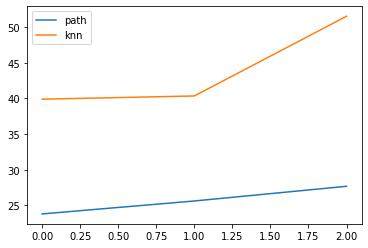

In [23]:
print(f"CIFAR-10: Path classifier accuracy = {100 * path / len(XYtest) / times:.2f}%")
print(f"CIFAR-10: Knn classifier accuracy = {100 * knn / len(XYtest) / times:.2f}%")

plt.plot(path_times, label="path")
plt.plot(knn_times, label="knn")
plt.legend()
plt.show()